# FEXHIS

The aim of the present notebook is to test the correct execution of the different steps described in the material and methods section of the article: "Automatic Segmentation of Cortical Bone Microstructure: Application and Analysis of Three Proximal Femur Sites".

The main steps are the following:
- Draw lines to define anatomical quadrants (inferior, superior, anterior, and posterior) based on uCT scans and slice geometry
- Design a model to perform automatic segmentation based on manual segmentations performed by multiple operators
- Select regions of interest (ROIs) to perform automatic segmentation
- Segment selected ROIs
- Analysis of segmentation results
- Perform statistics

This notebook assumes that the FEXHIS conda environment was created using the given requirement files

In [1]:
# Initialize

"""
Start importing the necessary packages and define the directory structure
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import SimpleITK as sitk
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.models import load_model # type: ignore
from skimage.morphology import disk
from sklearn.model_selection import KFold
from scipy.stats.distributions import norm
from keras import layers, Model, callbacks
from scipy.ndimage import maximum_filter as mf
from skimage import io, feature, color, filters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from Utils import *


def SetDirectories(Name:str) -> dict:

    """
    Return full path of the main project folders into a dictionary
    """

    CWD = str(Path.cwd())
    Start = CWD.find(Name)
    WD = Path(CWD[:Start], Name)
    Dirs = [D for D in WD.iterdir() if D.is_dir()]

    Directories = {}
    Directories['CWD'] = WD
    Directories['Data'] = [D for D in Dirs if 'Data' in D.name][0]
    Directories['Scripts'] = [D for D in Dirs if 'Scripts' in D.name][0]
    Directories['Results'] = [D for D in Dirs if 'Results' in D.name][0]

    return Directories

Dirs = SetDirectories('FEXHIP-Histology')
List = pd.read_csv(Dirs['Data'] / 'DonorsList.csv', index_col=[0])
Output = Dirs['Results'] / 'Test'
os.makedirs(Output, exist_ok=True)


Donor 01              [               ] 0%

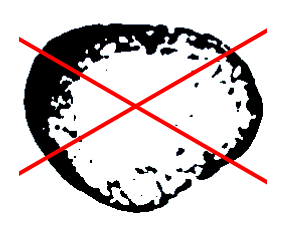

Lines printed!        [===============] 100%
Process executed in 00:00:01 (HH:MM:SS)


In [2]:
# Draw quadrants

"""
Select a uCT scanned femoral section and define anatomical quadrants according to the geometry
"""

def FillHoles(Image:sitk.Image, Radius=5) -> sitk.Image:

    """
    Fill holes of a binary Simple ITK image
    """

    Dimension = Image.GetDimension()

    if Dimension == 3:

        Crop = sitk.Crop(Image, (0, 0, Radius), (0, 0, Radius))
        Padded = sitk.ConstantPad(Crop, (0, 0, Radius), (0, 0, Radius), 2)
        Padded = sitk.ConstantPad(Padded, (Radius, Radius, Radius), (Radius, Radius, Radius))

        DilateFilter = sitk.BinaryDilateImageFilter()
        DilateFilter.SetForegroundValue(2)
        DilateFilter.SetKernelRadius(Radius)
        Dilated = DilateFilter.Execute(Padded)

        FillFilter = sitk.BinaryFillholeImageFilter()
        FillFilter.SetForegroundValue(2)
        Filled = FillFilter.Execute(Dilated)

        ErodeFilter = sitk.BinaryErodeImageFilter()
        ErodeFilter.SetForegroundValue(2)
        ErodeFilter.SetKernelRadius(Radius)
        Eroded = ErodeFilter.Execute(Filled)

        BinImage = sitk.Crop(Eroded, (Radius, Radius, Radius), (Radius, Radius, Radius))

    elif Dimension == 2:

        Padded = sitk.ConstantPad(Image, (Radius, Radius), (Radius, Radius))

        DilateFilter = sitk.BinaryDilateImageFilter()
        DilateFilter.SetForegroundValue(2)
        DilateFilter.SetKernelRadius(Radius)
        Dilated = DilateFilter.Execute(Padded)

        FillFilter = sitk.BinaryFillholeImageFilter()
        FillFilter.SetForegroundValue(2)
        Filled = FillFilter.Execute(Dilated)

        ErodeFilter = sitk.BinaryErodeImageFilter()
        ErodeFilter.SetForegroundValue(2)
        ErodeFilter.SetKernelRadius(Radius)
        Eroded = ErodeFilter.Execute(Dilated)

        BinImage = sitk.Crop(Eroded, (Radius, Radius), (Radius, Radius))

    return BinImage

def PrintImage(Image:sitk.Image, FileName:str, pCOG:tuple,
               X_Line:np.array, Y_Line:np.array, Show=True) -> None:

    """
    Print picture of uCT scan with lines defining anatomical quadrants
    """
    
    # Get image properties
    ImageSize = np.array(Image.GetSize())
    ImageSpacing = np.array(Image.GetSpacing())
    PhysicalSize = ImageSize * ImageSpacing

    # Set figure properties
    Inch = 25.4
    mm = 1 / Inch
    Subsampling = 1
    DPI = np.round(1 / ImageSpacing / Subsampling * Inch)[0]
    Margins = np.array([0., 0.])
    FigureSize = ImageSpacing * ImageSize * mm

    RealMargins = [Margins[0] / 2 * PhysicalSize[0] / (FigureSize[0] * Inch),
                    Margins[1] / 2 * PhysicalSize[1] / (FigureSize[1] * Inch),
                    1 - Margins[0] / 2 * PhysicalSize[0] / (FigureSize[0] * Inch),
                    1 - Margins[1] / 2 * PhysicalSize[1] / (FigureSize[1] * Inch)]

    # Generate figure and save it
    Figure, Axis = plt.subplots(1,1, figsize=FigureSize, dpi=int(DPI))
    Axis.imshow(sitk.GetArrayFromImage(Image), cmap='bone')
    Axis.plot(pCOG[0] + X_Line, pCOG[1] + Y_Line, color=(1, 0, 0))
    Axis.plot(pCOG[0] - X_Line, pCOG[1] + Y_Line, color=(1, 0, 0))
    Axis.plot(pCOG[0] + X_Line, pCOG[1] - Y_Line, color=(1, 0, 0))
    Axis.plot(pCOG[0] - X_Line, pCOG[1] - Y_Line, color=(1, 0, 0))
    Axis.set_xlim([0,Image.GetSize()[0]])
    Axis.set_ylim([Image.GetSize()[1],0])
    Axis.axis('off')
    plt.subplots_adjust(RealMargins[0], RealMargins[1], RealMargins[2], RealMargins[3])
    plt.savefig(FileName, dpi=int(DPI))
    if Show:
        plt.show()
    else:
        plt.close(Figure)

    return


# Define quadrant angle
Angle = 60

# Select donor
Idx = 1
Row = List.loc[Idx]
Time.Process(1, 'Donor ' + f"{Idx:02d}")

# Select sample uCT scan
Donor = 'Donor_' + f"{Idx:02d}"
DonorDir = Dirs['Data'] / Donor
File = DonorDir / 'Neck_Left.mhd'

# Read corresponding sample uct
Scan = sitk.ReadImage(str(File))
Array = sitk.GetArrayFromImage(Scan)

# Binarize image to find area centroid
OtsuFilter = sitk.OtsuMultipleThresholdsImageFilter()
OtsuFilter.SetNumberOfThresholds(2)
BinImage = OtsuFilter.Execute(Scan)

# Perform binary dilation and erosion to find center for proximal and distal slices
Filled = FillHoles(BinImage)

# Use distal slice for orientation computation
Slice = int(round(Filled.GetSize()[2]*0.1))

# Get orientation of filled slice
LabStat = sitk.LabelIntensityStatisticsImageFilter()
LabStat.Execute(Filled[:,:,Slice], Filled[:,:,Slice])
COGFilled = LabStat.GetCenterOfGravity(2)
X1, Y1, X2, Y2 = LabStat.GetPrincipalAxes(2)
OrientationAngle = -np.arctan(-X1 / Y1)

# Create according rotation transform
R = np.array([[np.cos(OrientationAngle), -np.sin(OrientationAngle), 0],
            [np.sin(OrientationAngle),  np.cos(OrientationAngle), 0],
            [                       0,                         0, 1]])

Transform = sitk.AffineTransform(3)
Transform.SetMatrix(R.ravel())
Transform.SetCenter((COGFilled[0], COGFilled[1], 0))
Transform.SetTranslation((0, 0, 0))

# Resample image (and pad to avoid out-of-view bone parts)
Resampler = sitk.ResampleImageFilter()
Pad = 50
Resampler.SetReferenceImage(sitk.ConstantPad(Scan,(Pad,Pad,0),(Pad,Pad,0)))
Resampler.SetTransform(Transform.GetInverse())
Rotated = Resampler.Execute(Scan)

# Check if inferior if on left
BinImage = OtsuFilter.Execute(Rotated)
LabStat.Execute(BinImage[:,:,Slice], BinImage[:,:,Slice])
COGBin = LabStat.GetCenterOfGravity(2)

if COGBin[0] > COGFilled[0]:
    Transform.SetMatrix([-1, 0, 0, 0, -1, 0, 0, 0, 1])
    Resampler.SetTransform(Transform.GetInverse())
    Rotated = Resampler.Execute(Rotated)

# Filter and crop imag to bone
Gauss = sitk.DiscreteGaussianImageFilter()
Gauss.SetVariance(0.05)
Gauss.SetMaximumKernelWidth(10)
Smooth = Gauss.Execute(Rotated[:,:,Slice])

BinImage = OtsuFilter.Execute(Smooth)
Array = sitk.GetArrayFromImage(BinImage)
Coords = np.where(Array == 2)
Cropped = BinImage[Coords[1].min()-5: Coords[1].max()+5,
                Coords[0].min()-5: Coords[0].max()+5]

# Get center of gravity (COG) of filled slice
COG = Filled[:,:,Slice].TransformPhysicalPointToIndex(COGFilled)
COG = (COG[0] - Coords[1].min() + Pad,
    COG[1] - Coords[0].min() + Pad)


# Compute cutting lines
X_Line = np.linspace(0,Cropped.GetSize()[0],100)
Y_Line = X_Line * np.tan(Angle/2 * np.pi/180)

# Print image with correct size
FileName = str(Output / (Donor + File.name[4:-4] + '.png'))
PrintImage(1 - (Cropped==2), FileName, COG, X_Line, Y_Line, Show=True)


Time.Process(0, 'Lines printed!')

In [3]:
# Perform data preprocessing steps

"""
Get training data, perform stain normalisation and data augmentation.
Save the results for model training
"""

def DataStats(Images:list, Plots=False) -> tuple:

    """
    Compute average and standard deviation of each canal
    for a list of images in the LAB space. Then, fit a
    normal distribution to these values and return the
    resulting parameters into two arrays
    """

    # Unfold Images list
    Images = [ii for i in Images for ii in i]
    Averages = np.zeros((len(Images),3))
    Stds = np.zeros((len(Images),3))

    # Store average and standard deviation in lab space
    for i, Image in enumerate(Images):
        LAB = color.rgb2lab(Image)
        Averages[i] = np.mean(LAB, axis=(0,1))
        Stds[i] = np.std(LAB, axis=(0,1), ddof=1)

    # Fit normal distribution
    aL = norm.fit(Averages[:,0])
    aA = norm.fit(Averages[:,1])
    aB = norm.fit(Averages[:,2])

    sL = norm.fit(Stds[:,0])
    sA = norm.fit(Stds[:,1])
    sB = norm.fit(Stds[:,2])
            
    return (np.array([aL, aA, aB]), np.array([sL, sA, sB]))
def StainAugmentation(Images:list, aLAB:np.array, sLAB:np.array, N:int) -> np.array:

    """
    Perform stain augmentation according to
        Shen et al. 2022
        RandStainNA: Learning Stain-Agnostic Features from Histology
        Slides by Bridging Stain Augmentation and Normalization
    """

    # Convert images into LAB space
    LAB = []
    S = Images[0].shape
    Time.Process(1,'Convert to LAB')
    for I in Images:
        lab = color.rgb2lab(I / 255)
        Nlab = []
        for _ in range(N):
            Nlab.append(lab)
        LAB.append(Nlab)
        Time.Update(len(LAB)/3/len(Images))
    LAB = np.array(LAB)

    # Define random transform parameters (reshape first to match data shape)
    Time.Update(1/3, 'Tranform Images')
    aLAB = np.tile(aLAB.T, N).reshape((2, N, 3), order='A')
    aLAB = np.tile(aLAB, len(Images)).reshape((2, len(Images), N, 3))
    sLAB = np.tile(sLAB.T, N).reshape((2, N, 3), order='A')
    sLAB = np.tile(sLAB, len(Images)).reshape((2, len(Images), N, 3))
    Mean = np.random.normal(aLAB[0], aLAB[1])
    Std = np.random.normal(sLAB[0], sLAB[1])

    # Normalize images according to random templates
    S = LAB.shape
    Norm = np.zeros(S)
    X_Bar = np.mean(LAB, axis=(2,3))
    S_X = np.std(LAB, axis=(2,3), ddof=1)

    X_Bar = np.tile(X_Bar, S[2]*S[3]).reshape(S)
    S_X = np.tile(S_X, S[2]*S[3]).reshape(S)
    Mean = np.tile(Mean, S[2]*S[3]).reshape(S)
    Std = np.tile(Std, S[2]*S[3]).reshape(S)

    Norm = (LAB - X_Bar) / S_X * Std + Mean

    # Convert back to RGB space
    Results = []
    Time.Update(2/3, 'Convert to RGB')
    for i in range(len(Images)):
        results = []
        for j in range(N):
            RGB = color.lab2rgb(Norm[i,j])
            results.append(RGB)
        Results.append(results)
        Time.Update(2/3 + i/3/len(Images))
    Results = np.array(Results) * 255

    Time.Process(0)

    return np.round(Results).astype('uint8')
def DataAugmentation(StainAug:np.array, Masks:np.array, ResultsPath:Path, N=8, ROISize=256) -> None:

    """
    Perform data augmentation and save results to directory
    :param    StainAug: Stain augmented data
    :param       Masks: Labels
    :param ResultsPath: Directory to save results
    :param           N: Augmentation factor
    :param     ROISize: Size of final ROI
    """


    Time.Process(1,'Augment Data')
    Path.mkdir(ResultsPath, exist_ok=True)
    Size = StainAug.shape[0] * StainAug.shape[1]
    for s, Stains in enumerate(StainAug):
        for i, Image in enumerate(Stains):
            for n in range(N):

                # Flip image
                if np.mod(n,2)-1:
                    fImage = Image
                    fLabel = Masks[s]
                elif np.mod(n,4)-1:
                    fImage = Image[::-1, :, :]
                    fLabel = Masks[s][::-1, :]
                else:
                    fImage = Image[:, ::-1, :]
                    fLabel = Masks[s][:, ::-1]

                # Rotate image of 90 degrees
                if n < 2:
                    rImage = fImage
                    rLabel = fLabel
                elif n < 4:
                    rImage = np.rot90(fImage,1)
                    rLabel = np.rot90(fLabel,1)
                elif n < 6:
                    rImage = np.rot90(fImage,2)
                    rLabel = np.rot90(fLabel,2)
                else:
                    rImage = np.rot90(fImage,3)
                    rLabel = np.rot90(fLabel,3)

                # Select random location
                Min = 0
                Max = rImage.shape[0] - ROISize
                X0, Y0 = np.random.randint(Min, Max, 2)
                ROI = rImage[X0:X0+ROISize, Y0:Y0+ROISize]
                Lab = rLabel[X0:X0+ROISize, Y0:Y0+ROISize]

                # Convert to uint8
                Lab = np.round(Lab*255).astype('uint8')

                # Save augmented image and label
                Name = 'ROI_%02d_%1d_%1d.png' % (s, i, n)
                io.imsave(ResultsPath / Name, ROI)
                Name = 'Lab_%02d_%1d_%1d.png' % (s, i, n)
                io.imsave(ResultsPath / Name, Lab, check_contrast=False)

        Time.Update((s+1) * (i+1) / Size)
    Time.Process(0)

    return


# Collect training data
TrainingPath = Dirs['Data'] / 'Training'
Names, Images, Labels = CVAT.GetData(TrainingPath)

# Collect individual segments as one-hot encoding
OneHot = CVAT.OneHot(Labels)

# Get common ROI
CommonName, CommonROI, SegRatio, Indices = CVAT.CommonROI()

# Compute sample weights
sWeights = CVAT.SampleWeights(OneHot, Indices, SegRatio)

# Keep only 1 occurence of common ROI
# Use agreement ratio as sample weight
ROIs = Images[~Indices]
Masks = np.expand_dims(sWeights[~Indices],-1) * OneHot[~Indices]
ROIs = np.concatenate([np.expand_dims(CommonROI, 0), ROIs])
Masks = np.concatenate([np.expand_dims(SegRatio, 0), Masks])

# Perform stain normalization
Norms = []
for ROI in ROIs:
    Norm = StainNA(ROI, Reference.Mean, Reference.Std)
    Norms.append(Norm)

# Stain augmentation
N = 2
AverageLAB, StdLAB = DataStats(Images)
AverageLAB[:,0] = Reference.Mean
StdLAB[:,0] = Reference.Std
StainAug = StainAugmentation(Norms, AverageLAB, StdLAB, N)

# Perform data augmentation
ResultsPath =  Dirs['Results'] / '01_Training' / 'Preprocessing'
os.makedirs(ResultsPath, exist_ok=True)
DataAugmentation(StainAug, Masks[:,:,:,1:], ResultsPath)



Collect CVAT data     [===============] 100%
Process executed in 00:00:00 (HH:MM:SS)

Perform encoding      [===============] 100%
Process executed in 00:00:00 (HH:MM:SS)

Perform encoding      [===============] 100%
Process executed in 00:00:00 (HH:MM:SS)

Compute sample weight [===============] 100%
Process executed in 00:00:00 (HH:MM:SS)

Convert to RGB        [===============] 100%
Process executed in 00:00:03 (HH:MM:SS)

Augment Data          [===============] 100%
Process executed in 00:00:10 (HH:MM:SS)


In [14]:
# Model training

"""
Define and train model for automatic segmentation based on training data
"""

def ConvolutionBlock(Input:layers.Layer, nFilters:int):

    """
    Classical convolutional block used in simple U-net models
    """

    Layer = layers.Conv2D(nFilters, 3, padding="same")(Input)
    Layer = layers.Activation("relu")(Layer)

    Layer = layers.Conv2D(nFilters, 3, padding="same")(Layer)
    Layer = layers.Activation("relu")(Layer)

    return Layer
def EncoderBlock(Input:layers.Layer, nFilters:int):

    """
    Classical encoder block used in simple U-net models
    """

    Layer = ConvolutionBlock(Input, nFilters)
    Pool = layers.MaxPool2D((2, 2))(Layer)
    return Layer, Pool
def DecoderBlock(Input:layers.Layer, SkipFeatures:layers.Layer, nFilters:int):
    
    """
    Classical decoder block used in simple U-net models    
    """

    Layer = layers.Conv2DTranspose(nFilters, (2, 2), strides=2, padding="same")(Input)
    Layer = layers.Concatenate()([Layer, SkipFeatures])
    Layer = ConvolutionBlock(Layer, nFilters)
    return Layer
def BuildUnet(InputShape:tuple, nClasses:int, nFilters=[64, 128, 256, 512, 1024]) -> Model:

    """
    Builds simple U-net model for semantic segmentataion
    Model doesn't comprise dropout or batch normalization to keep
    architecture as simple as possible
    :param InputShape: tuple of 2 numbers defining the U-net input shape
    :param nClasses: integer defining the number of classes to segment
    :param nFilters: list of number of filters for each layer
    :return Unet: keras unet model
    """
    
    Input = layers.Input(InputShape)
    if len(nFilters) == 3:
        
        Block = []
        Block.append(EncoderBlock(Input, nFilters[0]))
        Block.append(EncoderBlock(Block[-1][1], nFilters[1]))

        Bridge = ConvolutionBlock(Block[-1][1], nFilters[2])
        D = DecoderBlock(Bridge, Block[-1][0], nFilters[1])
        D = DecoderBlock(D, Block[0][0], nFilters[0])

    else:
        Block = []
        Block.append(EncoderBlock(Input, nFilters[0]))
        for i, nFilter in enumerate(nFilters[1:-1]):
            Block.append(EncoderBlock(Block[i][1], nFilter))

        Bridge = ConvolutionBlock(Block[-1][1], nFilters[-1])
        D = DecoderBlock(Bridge, Block[-1][0], nFilters[-2])

        for i, nFilter in enumerate(nFilters[-3::-1]):
            D = DecoderBlock(D, Block[-i+2][0], nFilter)

    # If binary classification, uses sigmoid activation function
    if nClasses == 2:
      Activation = 'sigmoid'
    else:
      Activation = 'softmax'

    Outputs = layers.Conv2D(nClasses, 1, padding="same", activation=Activation)(D)
    Unet = Model(Input, Outputs, name='U-Net')
    return Unet

ResultsDir = Dirs['Results'] / '01_Training'
DataPath = ResultsDir / 'Preprocessing'
Images, Labels = Training.GetData(DataPath)

# Get sample weights
sWeights, YData = Training.SetWeights(Labels)

# Define class weights
Counts = np.sum(YData, axis=(0,1,2))
cWeights = 1 / (Counts / sum(Counts) * len(Counts))

# Split into train and test data
XTrain, XTest, YTrain, YTest = train_test_split(Images/255, YData, random_state=42)
WTrain, WTest = train_test_split(sWeights, random_state=42)

# Build UNet
Unet = BuildUnet(XTrain.shape[1:], YTrain.shape[-1], nFilters=[8, 16, 32])
Unet.compile(optimizer='adam',
                loss='binary_focal_crossentropy',
                metrics=['accuracy'],
                loss_weights=[w for w in cWeights],
                weighted_metrics=['accuracy']
                )





Get training data     [===============] 100%
Process executed in 00:00:01 (HH:MM:SS)
Epoch 1/20


ValueError: No loss to compute. Provide a `loss` argument in `compile()`.

In [ ]:

# print(Unet.summary())
# EarlyStop = callbacks.EarlyStopping(monitor='accuracy', patience=100)
# ModelName = str(ResultsDir / 'UNet_reduced.hdf5')
# CheckPoint = callbacks.ModelCheckpoint(ModelName, monitor='accuracy',
#                                         mode='max', save_best_only=True)
History = Unet.fit(XTrain,YTrain, validation_data=(XTest,YTest,WTest),
                    verbose=2, epochs=20, # workers=8,
                    batch_size=32, steps_per_epoch=15,
                    # callbacks=[EarlyStop, CheckPoint],
                    sample_weight=WTrain)
HistoryDf = pd.DataFrame(History.history)
HistoryDf.to_csv(ResultsDir / 'History.csv', index=False)

# Plot history
HistoryDf = pd.read_csv(ResultsDir / 'History.csv')
Figure, Axis = plt.subplots(1,1)
Axis.plot(HistoryDf['weighted_accuracy'], color=(1,0,0), label='Training data')
Axis.plot(HistoryDf['val_weighted_accuracy'], color=(0,0,1), label='Validation data')
plt.legend()
plt.show(Figure)

# Load best model
Unet = load_model(ResultsDir / 'UNet.hdf5')